In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Importing libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.pipeline import Pipeline

from sklearn.preprocessing import MinMaxScaler

from imblearn.over_sampling import SMOTE, BorderlineSMOTE, SVMSMOTE, ADASYN

from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import GridSearchCV, HalvingGridSearchCV, train_test_split, RepeatedStratifiedKFold, cross_val_score, learning_curve
from sklearn.metrics import classification_report, fbeta_score, confusion_matrix, precision_recall_curve, auc, make_scorer

# Reading data

In [ ]:
# accepted_loans = pd.read_csv('/content/drive/MyDrive/ML-project-20212/data/elite.csv')


# my drive link
accepted_loans = pd.read_csv('/content/drive/MyDrive/accepted_2007_to_2018q4.csv/elite.csv')

In [ ]:
accepted_loans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1343380 entries, 0 to 1343379
Data columns (total 79 columns):
 #   Column                               Non-Null Count    Dtype  
---  ------                               --------------    -----  
 0   loan_amnt                            1343380 non-null  float64
 1   term                                 1343380 non-null  int64  
 2   int_rate                             1343380 non-null  float64
 3   installment                          1343380 non-null  float64
 4   annual_inc                           1343380 non-null  float64
 5   dti                                  1343380 non-null  float64
 6   delinq_2yrs                          1343380 non-null  float64
 7   fico_range_low                       1343380 non-null  float64
 8   fico_range_high                      1343380 non-null  float64
 9   inq_last_6mths                       1343380 non-null  float64
 10  open_acc                             1343380 non-null  float64
 11

In [ ]:
accepted_loans.head()

,loan_amnt,term,int_rate,installment,annual_inc,dti,delinq_2yrs,fico_range_low,fico_range_high,inq_last_6mths,...,purpose_small_business,purpose_vacation,purpose_wedding,initial_list_status_w,application_type_Joint App,home_ownership_MORTGAGE,home_ownership_NONE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT
0,3600.0,60,13.99,123.03,55000.0,5.91,0.0,675.0,679.0,1.0,...,0,0,0,1,0,1,0,0,0,0
1,24700.0,60,11.99,820.28,65000.0,16.06,1.0,715.0,719.0,4.0,...,1,0,0,1,0,1,0,0,0,0
2,20000.0,60,10.78,432.66,63000.0,10.78,0.0,695.0,699.0,0.0,...,0,0,0,1,1,1,0,0,0,0
3,10400.0,60,22.45,289.91,104433.0,25.37,1.0,695.0,699.0,3.0,...,0,0,0,1,0,1,0,0,0,0
4,11950.0,60,13.44,405.18,34000.0,10.20,0.0,690.0,694.0,0.0,...,0,0,0,1,0,0,0,0,0,1


In [ ]:
accepted_loans.shape

(1343380, 79)

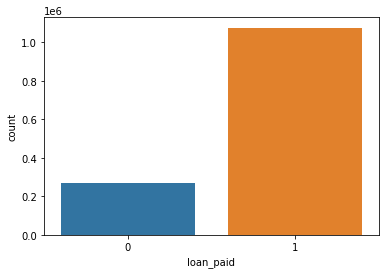

In [ ]:
sns.countplot(x=accepted_loans['loan_paid'], data=accepted_loans)

In [ ]:
num_fully_paid_loans = accepted_loans[accepted_loans['loan_paid'] == 1.0].shape[0]
num_charged_off_loans = accepted_loans[accepted_loans['loan_paid'] == 0.0].shape[0]
print("The number of Fully Paid loans: ", num_fully_paid_loans)
print("The number of Default loans: ", num_charged_off_loans)
print("Fully Paid / Default Ratio: ", num_fully_paid_loans / num_charged_off_loans)

The number of Fully Paid loans:  1075191
The number of Default loans:  268189
Fully Paid / Default Ratio:  4.009079417873216


# Data Processing

## Preparing parameters

### Features and Labels

In [ ]:
X = accepted_loans.loc[:, accepted_loans.columns != 'loan_paid'].values
y = accepted_loans['loan_paid'].values

### Train-Test split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [ ]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(1074704, 78) (1074704,)
(268676, 78) (268676,)


### Param grid for searching

In [ ]:
param_grid = {}

In [ ]:
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=42)

## Outliers handling

In [ ]:
accepted_loans.hist(figsize=(80, 100))
plt.show()

KeyboardInterrupt: ignored

In [ ]:
for i in range(0, 70, 10):
    plt.figure(figsize=(15, 10))
    sns.boxplot(data=accepted_loans.iloc[:, i: i + 10], orient='h')
    plt.show()

### Outliers Detection

### Outliers Treating

## Scaler

From plotting the histogram of each input variable, we see that almost variables are located in just 2 bins while others have skewed distribution -> It's better to use MinMaxScaler

In [ ]:
minmax_scaler = ('minmax', MinMaxScaler())

## Imbalanced data handling

### SMOTE

In [ ]:
smote = ('smote', SMOTE(sampling_strategy=1.0, random_state=42))
smote_param_grid = {
    'smote__sampling_strategy': [0.8, 0.9, 1.0]
    #'smote__k_neighbors': [3, 5, 10, 15]
}

### BorderlineSMOTE

In [ ]:
borderline_smote = ('borderline_smote', BorderlineSMOTE(sampling_strategy=1.0, random_state=42))
borderline_smote_param_grid = {
    'borderline_smote__sampling_strategy': np.arange(0.8, 1.01, 0.05),
    'borderline_smote__k_neighbors': [3, 5, 8, 10, 12],
    'borderline_smote__m_neighbors': [5, 10, 12, 15, 18],
}

### SVMSMOTE

In [ ]:
svm_smote = ('svm_smote', SVMSMOTE(sampling_strategy=1.0, random_state=42))
svm_smote_param_grid = {
    'svm_smote__sampling_strategy': np.arange(0.8, 1.01, 0.05),
    'svm_smote__k_neighbors': [3, 5, 8, 10, 12],
    'svm_smote__m_neighbors': [5, 10, 12, 15, 18]
}

### ADASYN

In [ ]:
adasyn = ('adasyn', ADASYN(sampling_strategy=1.0, random_state=42))
adasyn_param_grid = {
    'adasyn__sampling_strategy': np.arange(0.8, 1.01, 0.05),
    'adasyn__n_neighbors': [3, 5, 8, 10, 12]
}

# Modeling

## Classical models

### Perceptron

In [ ]:
perceptron = ('perceptron', Perceptron())
perception_param_grid = {
    
}

### Logistic Regression

In [ ]:
lr = ('lr', LogisticRegression())
lr_param_grid = {
    'lr__C': [0.01, 0.1, 1, 10, 100],
    'lr__penalty': ['l2'],
    'lr__max_iter': [100, 500, 1000],
    'lr__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
}

### KNN

### SVM

### Decision Tree

## Ensemble models

### Random Forest

In [ ]:
rf = ('rf', RandomForestClassifier())
rf_param_grid = {
    'rf__max_features' : ['sqrt', 'log2'],
    'rf__n_estimators' : [10, 100, 1000]
}

### XGBoost

In [ ]:
xgboost = ('xgboost', XGBClassifier())
xgboost_param_grid = {
      #for now left empty
}

### AdaBoost

## Deep learning models

### MLP

### ANN

# Training and Evaluation





In [ ]:
# Metric
f_onehalf_scorer = make_scorer(fbeta_score, beta=0.5)

In [ ]:
def plot_learning_curve(
    estimator,
    title,
    X,
    y,
    axes=None,
    ylim=None,
    cv=cv,
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 5),
):
    if axes is None:
        _, axes = plt.subplots(3, 1, figsize=(15, 15))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(
        estimator,
        X,
        y,
        cv=cv,
        n_jobs=n_jobs,
        train_sizes=train_sizes,
        scoring=f_onehalf_scorer,
        return_times=True,
        random_state=42
    )
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color="r",
    )
    axes[0].fill_between(
        train_sizes,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
        color="g",
    )
    axes[0].plot(
        train_sizes, train_scores_mean, "o-", color="r", label="Training score"
    )
    axes[0].plot(
        train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score"
    )
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, "o-")
    axes[1].fill_between(
        train_sizes,
        fit_times_mean - fit_times_std,
        fit_times_mean + fit_times_std,
        alpha=0.1,
    )
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    fit_time_argsort = fit_times_mean.argsort()
    fit_time_sorted = fit_times_mean[fit_time_argsort]
    test_scores_mean_sorted = test_scores_mean[fit_time_argsort]
    test_scores_std_sorted = test_scores_std[fit_time_argsort]
    axes[2].grid()
    axes[2].plot(fit_time_sorted, test_scores_mean_sorted, "o-")
    axes[2].fill_between(
        fit_time_sorted,
        test_scores_mean_sorted - test_scores_std_sorted,
        test_scores_mean_sorted + test_scores_std_sorted,
        alpha=0.1,
    )
    axes[2].set_xlabel("fit_times") 
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt

In [ ]:
def plot_search_results(search):
    """
    Params: 
        search: A trained GridSearchCV object.
    """
    ## Results from grid search
    results = search.cv_results_
    means_test = results['mean_test_score']
    stds_test = results['std_test_score']
    means_train = results['mean_train_score']
    stds_train = results['std_train_score']

    ## Getting indexes of values per hyper-parameter
    masks=[]
    masks_names= list(search.best_params_.keys())
    for p_k, p_v in search.best_params_.items():
        masks.append(list(results['param_'+p_k].data==p_v))

    params=search.param_grid

    ## Ploting results
    fig, ax = plt.subplots(len(params), 1, sharex='none', sharey='all',figsize=(15,7 * len(params)))
    fig.suptitle('Score per parameter')
    fig.text(0.04, 0.5, 'MEAN SCORE', va='center', rotation='vertical')
    pram_preformace_in_best = {}
    for i, p in enumerate(masks_names):
        m = np.stack(masks[:i] + masks[i+1:])
        pram_preformace_in_best
        best_parms_mask = m.all(axis=0)
        best_index = np.where(best_parms_mask)[0]
        x = np.array(params[p])
        y_1 = np.array(means_test[best_index])
        e_1 = np.array(stds_test[best_index])
        y_2 = np.array(means_train[best_index])
        e_2 = np.array(stds_train[best_index])
        ax[i].errorbar(x, y_1, e_1, linestyle='--', marker='o', label='test')
        ax[i].errorbar(x, y_2, e_2, linestyle='-', marker='^',label='train' )
        ax[i].set_xlabel(p.upper())

    plt.legend()
    plt.show()

In [ ]:
def print_result_df(search):
  keeping_columns = ['params', 'mean_train_score', 'std_train_score', 'mean_test_score', 'std_test_score', 'mean_fit_time', 'std_fit_time']
  df = pd.DataFrame(search.cv_results_)
  df = df[keeping_columns].sort_values(by='mean_test_score', ascending=False)
  return df

In [ ]:
def print_best_model_result(search, name):
  print("Best parameter (CV score=):" % search.best_score_)
  best_model = search.best_estimator_
  print(best_model)

  y_pred = best_model.predict(X_test)
  y_score = best_model.predict_proba(X_test)[:, 1]

  print(classification_report(y_test, y_pred))
  print(confusion_matrix(y_test, y_pred))

  # calculate precision and recall for each threshold
  precision, recall, threshold = precision_recall_curve(y_test, y_score)
  # calculate scores
  f_onehalf_score, pr_auc = fbeta_score(y_test, y_pred, beta=0.5), auc(recall, precision)
  print('f0.5_score=', f_onehalf_score)
  print('pr_auc_score=', pr_auc)

  # calculate the no skill line as the proportion of the positive class
  no_skill = len(y_test[y_test==1]) / len(y_test)
  # plot the no skill precision-recall curve
  plt.figure(figsize=(10, 7))
  plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
  # plot the model precision-recall curve
  plt.plot(recall, precision, marker='.', label=name)
  plt.title(f'{name}(pr_auc={pr_auc})')
  plt.xlabel('Recall')
  plt.ylabel('Precision')
  # show the legend
  plt.legend()
  # show the plot
  plt.show()

  plot_learning_curve(best_model, name, X_train, y_train, cv=cv, n_jobs=-1 )
  plt.show()

  return best_model, f_onehalf_score, pr_auc

## Logistic Regression

### Base model

In [ ]:
pipe = Pipeline(steps=[lr])

In [ ]:
param_grid = {}

In [ ]:
# HalvingGridSearch 
search = HalvingGridSearchCV(pipe, param_grid, scoring=f_onehalf_scorer, cv=cv, verbose=3, return_train_score=True)

In [ ]:
search.fit(X_train, y_train)

n_iterations: 1
n_required_iterations: 1
n_possible_iterations: 1
min_resources_: 1074704
max_resources_: 1074704
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 1
n_resources: 1074704
Fitting 10 folds for each of 1 candidates, totalling 10 fits


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 1/10] END .............., score=(train=0.882, test=0.883) total time=  30.3s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 2/10] END .............., score=(train=0.876, test=0.876) total time=  29.0s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 3/10] END .............., score=(train=0.874, test=0.875) total time=  30.1s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 4/10] END .............., score=(train=0.874, test=0.875) total time=  28.5s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 5/10] END .............., score=(train=0.875, test=0.873) total time=  27.1s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 6/10] END .............., score=(train=0.874, test=0.875) total time=  27.4s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 7/10] END .............., score=(train=0.875, test=0.876) total time=  28.4s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 8/10] END .............., score=(train=0.875, test=0.875) total time=  30.1s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 9/10] END .............., score=(train=0.875, test=0.874) total time=  26.7s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 10/10] END ............., score=(train=0.873, test=0.873) total time=  28.2s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


HalvingGridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=2, n_splits=5, random_state=42),
                    estimator=Pipeline(steps=[('lr', LogisticRegression())]),
                    param_grid={}, scoring=make_scorer(fbeta_score, beta=0.5),
                    verbose=3)

In [ ]:
print_result_df(search)

,params,mean_train_score,std_train_score,mean_test_score,std_test_score,mean_fit_time,std_fit_time
0,{},0.875393,0.002483,0.875403,0.002635,28.410016,1.227689


Best parameter (CV score=):
Pipeline(steps=[('lr', LogisticRegression())])
              precision    recall  f1-score   support

           0       0.66      0.37      0.47     53638
           1       0.86      0.95      0.90    215038

    accuracy                           0.84    268676
   macro avg       0.76      0.66      0.69    268676
weighted avg       0.82      0.84      0.82    268676

[[ 19662  33976]
 [ 10108 204930]]
f0.5_score= 0.8752739902721709
pr_auc_score= 0.9734273488035371


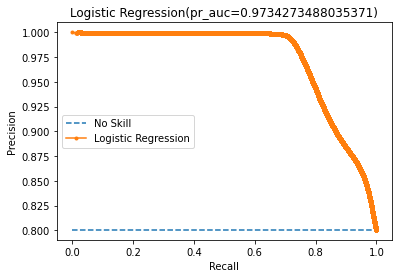

/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


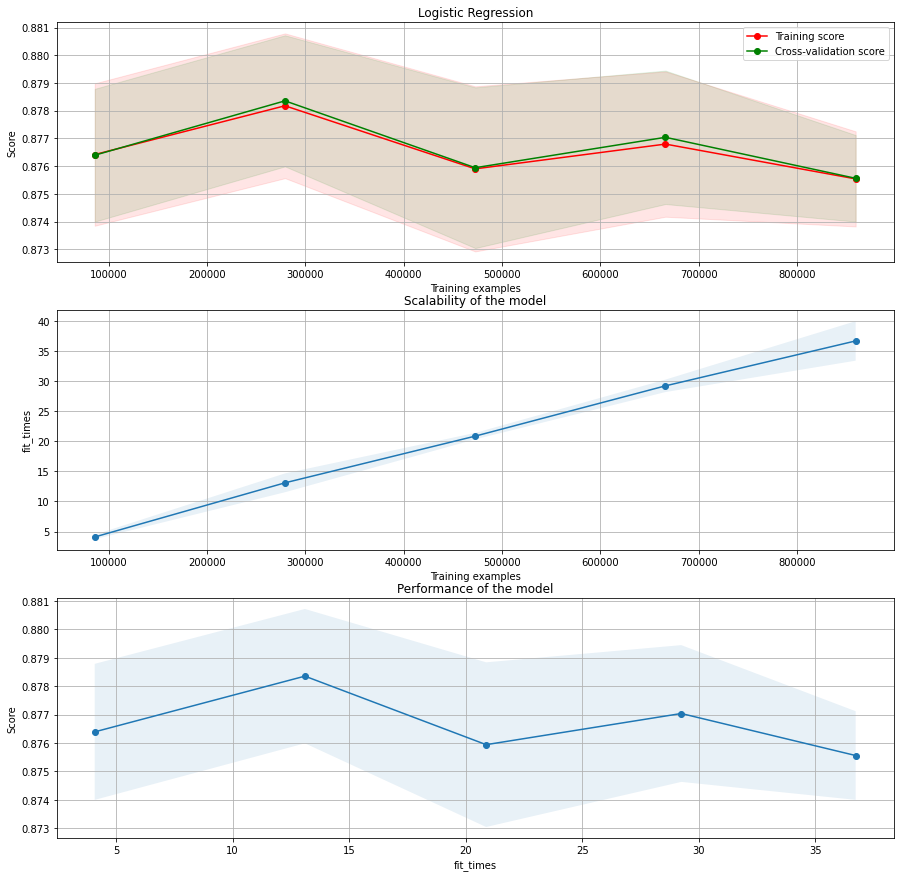

(Pipeline(steps=[('lr', LogisticRegression())]),
 0.8752739902721709,
 0.9734273488035371)

In [ ]:
print_best_model_result(search, 'Logistic Regression')

### MinMaxScaler + Logistic Regression

In [ ]:
pipe = Pipeline(steps=[minmax_scaler, lr])

In [ ]:
param_grid = {}

In [ ]:
# HalvingGridSearch 
search = HalvingGridSearchCV(pipe, param_grid, scoring=f_onehalf_scorer, cv=cv, verbose=3, return_train_score=True)

In [ ]:
search.fit(X_train, y_train)

n_iterations: 1
n_required_iterations: 1
n_possible_iterations: 1
min_resources_: 1074704
max_resources_: 1074704
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 1
n_resources: 1074704
Fitting 10 folds for each of 1 candidates, totalling 10 fits


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 1/10] END .............., score=(train=0.904, test=0.904) total time=  32.1s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 2/10] END .............., score=(train=0.904, test=0.904) total time=  28.2s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 3/10] END .............., score=(train=0.904, test=0.905) total time=  28.0s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 4/10] END .............., score=(train=0.904, test=0.904) total time=  28.6s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 5/10] END .............., score=(train=0.904, test=0.903) total time=  28.4s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 6/10] END .............., score=(train=0.904, test=0.904) total time=  28.9s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 7/10] END .............., score=(train=0.905, test=0.906) total time=  27.5s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 8/10] END .............., score=(train=0.904, test=0.904) total time=  26.8s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 9/10] END .............., score=(train=0.904, test=0.904) total time=  25.9s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 10/10] END ............., score=(train=0.904, test=0.904) total time=  29.0s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


HalvingGridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=2, n_splits=5, random_state=42),
                    estimator=Pipeline(steps=[('minmax', MinMaxScaler()),
                                              ('lr', LogisticRegression())]),
                    param_grid={}, scoring=make_scorer(fbeta_score, beta=0.5),
                    verbose=3)

In [ ]:
print_result_df(search)

,params,mean_train_score,std_train_score,mean_test_score,std_test_score,mean_fit_time,std_fit_time
0,{},0.90422,0.000218,0.904204,0.000739,28.013788,1.553189


Best parameter (CV score=):
Pipeline(steps=[('minmax', MinMaxScaler()), ('lr', LogisticRegression())])
              precision    recall  f1-score   support

           0       0.71      0.55      0.62     53638
           1       0.89      0.94      0.92    215038

    accuracy                           0.87    268676
   macro avg       0.80      0.75      0.77    268676
weighted avg       0.86      0.87      0.86    268676

[[ 29450  24188]
 [ 11995 203043]]
f0.5_score= 0.9032467289819406
pr_auc_score= 0.981304676341752


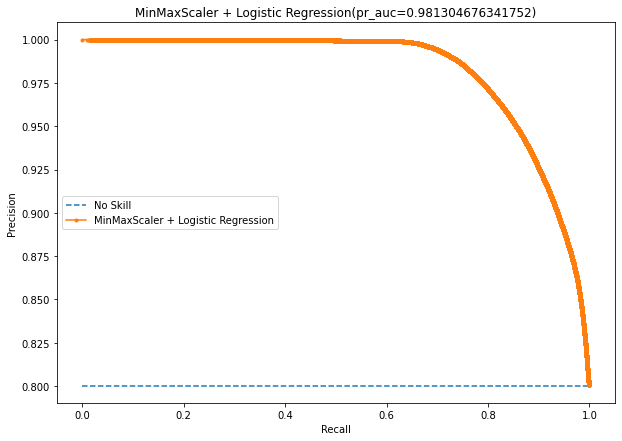

/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


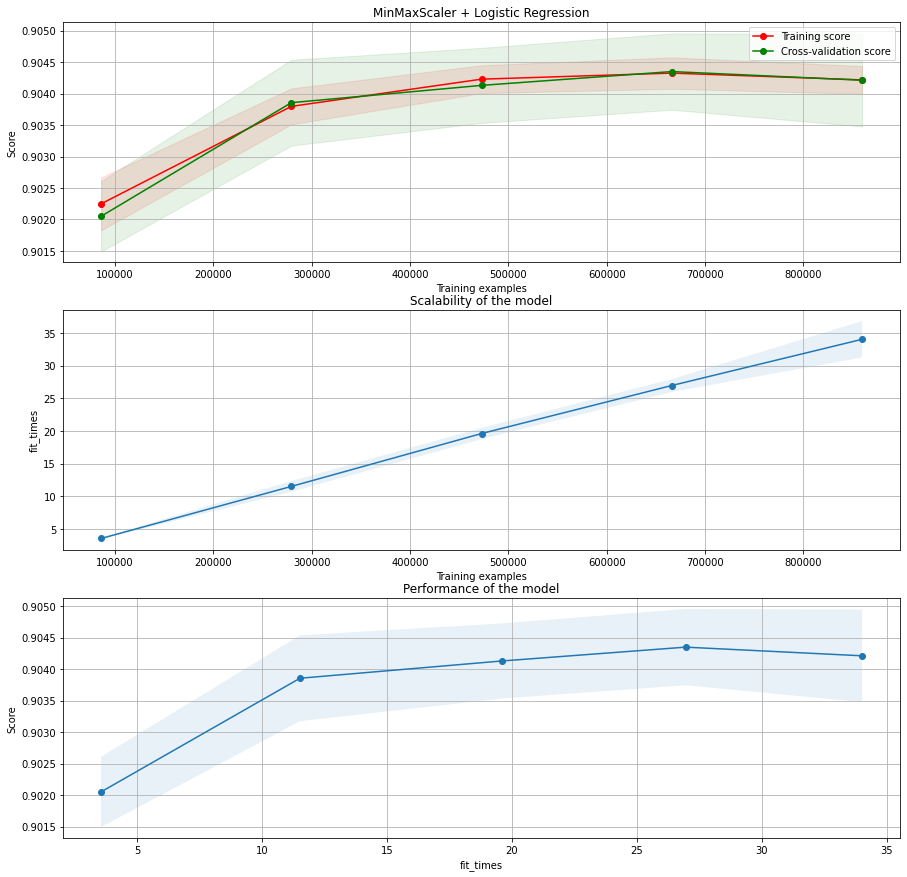

(Pipeline(steps=[('minmax', MinMaxScaler()), ('lr', LogisticRegression())]),
 0.9032467289819406,
 0.981304676341752)

In [ ]:
print_best_model_result(search, 'MinMaxScaler + Logistic Regression')

### MinMaxScale + SMOTE + Logistic Regression

In [ ]:
pipe = Pipeline(steps=[minmax_scaler, smote, lr])

In [ ]:
param_grid = {}

In [ ]:
search = HalvingGridSearchCV(pipe, param_grid, scoring=f_onehalf_scorer, cv=cv, verbose=4, return_train_score=True)

In [ ]:
search.fit(X_train, y_train)

n_iterations: 1
n_required_iterations: 1
n_possible_iterations: 1
min_resources_: 1074704
max_resources_: 1074704
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 1
n_resources: 1074704
Fitting 10 folds for each of 1 candidates, totalling 10 fits


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 1/10] END .............., score=(train=0.932, test=0.932) total time=12.3min


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 2/10] END .............., score=(train=0.932, test=0.931) total time=12.5min


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 3/10] END .............., score=(train=0.931, test=0.932) total time=12.8min


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 4/10] END .............., score=(train=0.932, test=0.931) total time=12.7min


In [ ]:
print_result_df(search)

In [ ]:
print_best_model_result(search, 'MinMaxScaler + SMOTE + Logistic Regression')

### Tuning Logistic Regression

In [ ]:
pipe = Pipeline(steps=[minmax_scaler, smote, lr])

In [ ]:
param_grid = lr_param_grid

In [ ]:
search = HalvingGridSearchCV(pipe, param_grid, scoring=f_onehalf_scorer, cv=cv, verbose=3, return_train_score=True)

In [ ]:
search.fit(X_train, y_train)

In [ ]:
print_result_df(search)

In [ ]:
# Plot effect of each param when fixing other params at its best value in pipeline
plot_search_results(search)

In [ ]:
print_best_model_result(search, 'MinMaxScaler + SMOTE + Tuning Logistic Regression')

### Tuning Smote + Logistic Regression

In [ ]:
pipe = Pipeline(steps=[minmax_scaler, smote, lr])

In [ ]:
param_grid = {**smote_param_grid, **lr_param_grid}

In [ ]:
search = HalvingGridSearchCV(pipe, param_grid, scoring=f_onehalf_scorer, cv=cv, verbose=3, return_train_score=True)

In [ ]:
search.fit(X_train, y_train)

In [ ]:
print_result_df(search)

In [ ]:
plot_search_results(search)

In [ ]:
print_best_model_result(search, 'MinMaxScaler + Tuning SMOTE + Tuning Logistic Regression')

##Random Forest 


###Base model

In [ ]:
pipe = Pipeline(steps=[rf])

In [ ]:
param_grid = {}

In [ ]:
search = HalvingGridSearchCV(pipe, param_grid, scoring=f_onehalf_scorer, cv=cv, verbose=3, return_train_score=True)

In [ ]:
search.fit(X_train, y_train)

n_iterations: 1
n_required_iterations: 1
n_possible_iterations: 1
min_resources_: 1074704
max_resources_: 1074704
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 1
n_resources: 1074704
Fitting 10 folds for each of 1 candidates, totalling 10 fits
[CV 1/10] END .............., score=(train=1.000, test=0.920) total time= 6.2min
[CV 2/10] END .............., score=(train=1.000, test=0.921) total time= 7.2min
[CV 3/10] END .............., score=(train=1.000, test=0.922) total time= 7.1min
[CV 4/10] END .............., score=(train=1.000, test=0.921) total time= 6.7min
[CV 5/10] END .............., score=(train=1.000, test=0.920) total time= 6.5min
[CV 6/10] END .............., score=(train=1.000, test=0.921) total time= 6.5min
[CV 7/10] END .............., score=(train=1.000, test=0.921) total time= 6.2min
[CV 8/10] END .............., score=(train=1.000, test=0.921) total time= 5.9min
[CV 9/10] END .............., score=(train=1.000, test=0.920) total time= 5.8min


HalvingGridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=2, n_splits=5, random_state=42),
                    estimator=Pipeline(steps=[('rf',
                                               RandomForestClassifier())]),
                    param_grid={}, scoring=make_scorer(fbeta_score, beta=0.5),
                    verbose=3)

In [ ]:
print_result_df(search)

,params,mean_train_score,std_train_score,mean_test_score,std_test_score,mean_fit_time,std_fit_time
0,{},0.999998,0.000001,0.920658,0.00051,376.31206,25.921152


Best parameter (CV score=):
Pipeline(steps=[('rf', RandomForestClassifier())])
              precision    recall  f1-score   support

           0       0.76      0.64      0.70     53638
           1       0.91      0.95      0.93    215038

    accuracy                           0.89    268676
   macro avg       0.84      0.80      0.82    268676
weighted avg       0.88      0.89      0.89    268676

[[ 34501  19137]
 [ 10697 204341]]
f0.5_score= 0.9213264800036071
pr_auc_score= 0.9864179711499587


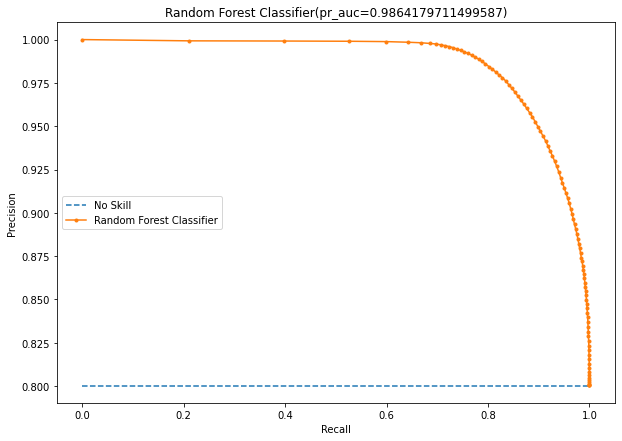

/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


In [ ]:
print_best_model_result(search, 'Random Forest Classifier')

### MinMaxScaler + Random Forest Classifier

In [ ]:
pipe = Pipeline(steps=[minmax_scaler, rf])

In [ ]:
param_grid = {}

In [ ]:
search = HalvingGridSearchCV(pipe, param_grid, scoring=f_onehalf_scorer, cv=cv, verbose=3, return_train_score=True)

In [ ]:
search.fit(X_train, y_train)

In [ ]:
print_result_df(search)

In [ ]:
print_best_model_result(search, 'MinMaxScaler + Random Forest Classifier')

### MinMaxScaler + SMOTE + Random Forest Classifier

In [ ]:
# pipe = Pipeline(steps=[minmax_scaler, smote, rf])

In [ ]:
# param_grid = {}

In [ ]:
# search = HalvingGridSearchCV(pipe, param_grid, scoring=f_onehalf_scorer, cv=cv, verbose=3, return_train_score=True)

In [ ]:
# search.fit(X_train, y_train)

In [ ]:
# print_result_df(search)

In [ ]:
# print_best_model_result(search, 'MinMaxScaler + SMOTE + Random Forest Classifier')

### MinMaxScaler  + Tunning Random Forest Classifier



In [ ]:
pipe = Pipeline(steps=[minmax_scaler, rf])

In [ ]:
param_grid = rf_param_grid

In [ ]:
search = HalvingGridSearchCV(pipe, param_grid, scoring=f_onehalf_scorer, cv=cv, verbose=3, return_train_score=True)

In [ ]:
search.fit(X_train, y_train)

In [ ]:
print_result_df(search)

In [ ]:
plot_search_results(search)

In [ ]:
print_best_model_result(search, 'MinMaxScaler  + Tunning Random Forest Classifier')

## XGBoost

### Base model

In [ ]:
pipe = Pipeline(steps=[xgboost])

In [ ]:
param_grid = {}

In [ ]:
search = HalvingGridSearchCV(pipe, param_grid, scoring=f_onehalf_scorer, cv=cv, verbose=3, return_train_score=True)

In [ ]:
search.fit(X_train, y_train)

n_iterations: 1
n_required_iterations: 1
n_possible_iterations: 1
min_resources_: 1074704
max_resources_: 1074704
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 1
n_resources: 1074704
Fitting 10 folds for each of 1 candidates, totalling 10 fits
[CV 1/10] END .............., score=(train=0.920, test=0.920) total time= 3.1min
[CV 2/10] END .............., score=(train=0.921, test=0.920) total time= 3.1min
[CV 3/10] END .............., score=(train=0.921, test=0.921) total time= 3.0min
[CV 4/10] END .............., score=(train=0.920, test=0.920) total time= 3.0min
[CV 5/10] END .............., score=(train=0.921, test=0.921) total time= 3.0min
[CV 6/10] END .............., score=(train=0.920, test=0.920) total time= 2.9min
[CV 7/10] END .............., score=(train=0.920, test=0.920) total time= 2.9min
[CV 8/10] END .............., score=(train=0.920, test=0.920) total time= 2.9min
[CV 9/10] END .............., score=(train=0.920, test=0.920) total time= 3.0min


HalvingGridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=2, n_splits=5, random_state=42),
                    estimator=Pipeline(steps=[('xgboost', XGBClassifier())]),
                    param_grid={}, scoring=make_scorer(fbeta_score, beta=0.5),
                    verbose=3)

In [ ]:
print_result_df(search)

,params,mean_train_score,std_train_score,mean_test_score,std_test_score,mean_fit_time,std_fit_time
0,{},0.920363,0.000241,0.920223,0.000504,178.637775,2.997294


Best parameter (CV score=):
Pipeline(steps=[('xgboost', XGBClassifier())])
              precision    recall  f1-score   support

           0       0.73      0.65      0.69     53638
           1       0.92      0.94      0.93    215038

    accuracy                           0.88    268676
   macro avg       0.82      0.80      0.81    268676
weighted avg       0.88      0.88      0.88    268676

[[ 34909  18729]
 [ 12717 202321]]
f0.5_score= 0.920278411044742
pr_auc_score= 0.9859853315541941


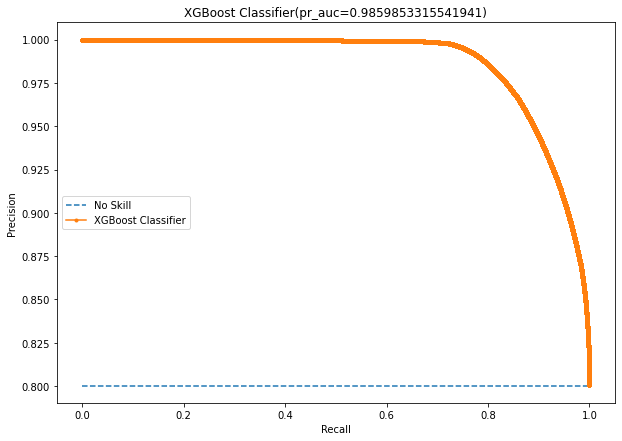

/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


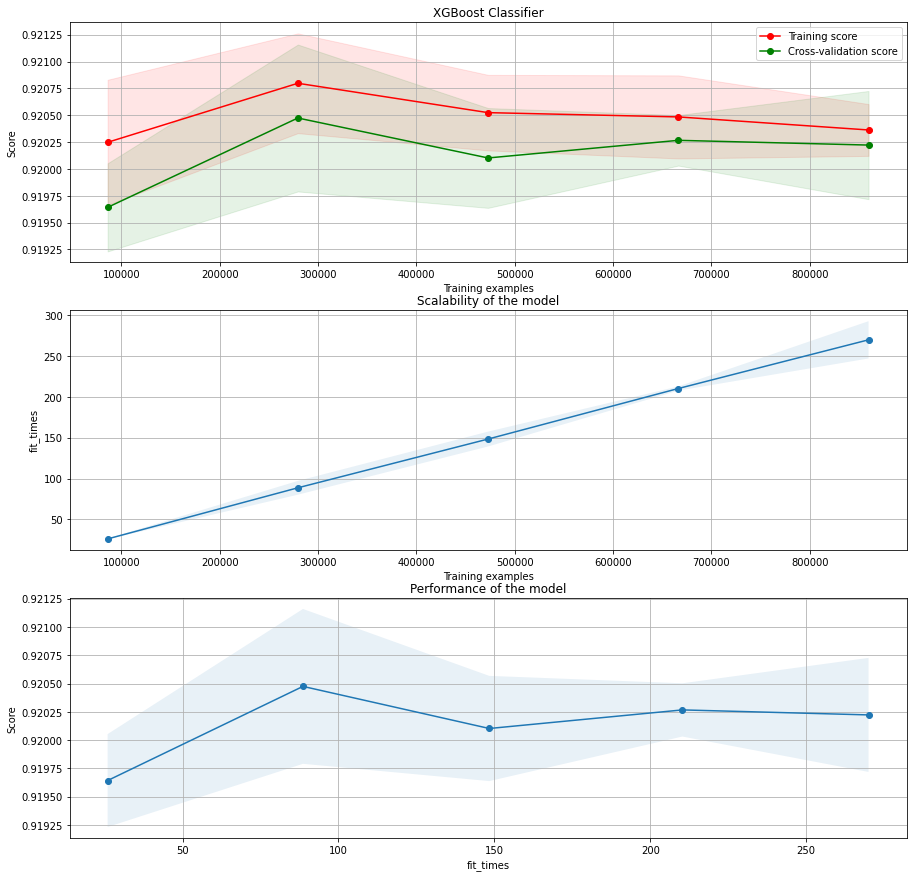

(Pipeline(steps=[('xgboost', XGBClassifier())]),
 0.920278411044742,
 0.9859853315541941)

In [ ]:
print_best_model_result(search, 'XGBoost Classifier')

### MinMaxScaler + XGBoost 

In [ ]:
pipe = Pipeline(steps=[minmax_scaler, xgboost])

In [ ]:
param_grid = {}

In [ ]:
search = HalvingGridSearchCV(pipe, param_grid, scoring=f_onehalf_scorer, cv=cv, verbose=3, return_train_score=True)

In [ ]:
search.fit(X_train, y_train)

In [ ]:
print_result_df(search)

In [ ]:
print_best_model_result(search, 'MinMaxScaler + XGBoost Classifier')

crash RAM